# Implementation of SVM Classifer: Terror and tourism

The aim is to train an algorithm to spot violence against tourists in news articles.  Here we implement a SVM Classifier using the unigram text and plotted the ROC and Precision/Recall graphs.

The context is the economic consequences of media coverage. This work was developed by Hannes Mueller, Tim Besley and Thiemo Fetzer (
https://www.barcelonagse.eu/research/working-papers/terror-and-tourism-economic-consequences-media-coverage). The data is not available as the work is unpublished.

# Load packages

In [68]:
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import scikitplot.metrics as metrics 
from sklearn.metrics import roc_auc_score

# Preprocessing code

In [ ]:
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin'

#this is loading a dataset of news items on chinese news on Turkey
filename ="extended_data_train.csv"
# uploading the data
corpus_data = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
corpus_data.info()

#issuing_iso3c is the origin of the news
#TITLE_EN is the title in english
#TEXT_EN is the title in english
#these two make our text data

#we had an RA code a subset of these news items so that they contain labels
#label_1 is indicating whether there was fatal violence (coded by a Research Assistant)
#label_2 is indicating whether a tourist was attacked (coded by a Research Assistant)


#getting a library of stopwords and defining a lemmatizer
new_stopwords = set(stopwords.words('english'))
lmtzr = WordNetLemmatizer()

corpus_data['titles_lemm'] = ""
for ind,line in corpus_data.iterrows():
    tit = corpus_data.TITLE_EN.iloc[ind]
    tit_tok = nltk.word_tokenize(tit)
    tit_lem = []
    for tok in tit_tok:
        tit_lem.append(lmtzr.lemmatize(tok.lower()))
    tit_filter = [word for word in tit_lem if word not in new_stopwords]
    tit_filter_dop = [word for word in tit_filter if word not in "'s"]
    tit_filter_dop = [sub('[^\w|\s]', '', f'{w}') for w in tit_filter_dop]  # change 1: adj preprocessing
    tit_string = ' '.join(tit_filter_dop)
    if tit_string == ' ':
        corpus_data.at[ind, 'titles_lemm']='---'
    else:
        corpus_data.at[ind, 'titles_lemm']=tit_string
        
corpus_data=corpus_data.dropna(subset=['titles_lemm'])
corpus_data=corpus_data.reset_index() 

print("done with titles")

corpus_data['text_with_head_lemm'] = ""
for ind,line in corpus_data.iterrows():
    #tit = corpus_data.TXT_EN.iloc[ind] # or keeping text only (title is already included)
    tit = corpus_data.TITLE_EN.iloc[ind] + ' ' + corpus_data.TXT_EN.iloc[ind] # change 2: add space
    tit_tok = nltk.word_tokenize(tit)
    tit_lem = []
    for tok in tit_tok:
        tit_lem.append(lmtzr.lemmatize(tok.lower()))
    tit_filter = [word for word in tit_lem if word not in new_stopwords]
    tit_filter_dop = [word for word in tit_filter if word not in "'s"]
    tit_filter_dop = [sub('[^\w|\s]', '', f'{w}') for w in tit_filter_dop]  # change 3: adj preprocessing
    tit_string = ' '.join(tit_filter_dop)
    if tit_string == ' ':
        corpus_data.at[ind,'text_with_head_lemm']='---'
    else:
        corpus_data.at[ind,'text_with_head_lemm']=tit_string

print("done with text plus titles")

corpus_data = corpus_data[pd.notna(corpus_data.label_1)].reset_index(drop=True)
corpus_data = corpus_data.dropna(subset=['titles_lemm']).reset_index(drop=True)

corpus_data  = corpus_data[['text_with_head_lemm', 'titles_lemm',
                          'label_0','label_1','label_2','label_3']]
corpus_data.info()

# SVM classifier

In [ ]:
# Preprocess data

cv1 = CountVectorizer(ngram_range = (1,1), min_df=50)
cv1.fit(Titles)
vectorized_titles1=cv1.transform(Titles)
cv1.fit(Texts)
vectorized_text1=cv1.transform(Texts)

print("Done with vectorizing")

svd = TruncatedSVD(100)
svd.fit(vectorized_titles1)
reduced_titles1=svd.transform(vectorized_titles1)
svd.fit(vectorized_text1)
reduced_text1=svd.transform(vectorized_text1)

print("Done with pre-processing")

In [ ]:
# Train test split
labels_2_np=np.array(labels_2)
X_train, X_test, y_train_l2, y_test_l2 = train_test_split(reduced_text1, labels_2_np, test_size=0.33, random_state=100)

# Gridsearch parameters
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

# Gridsearch with Support Vector Machine - Classifier
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X_train, y_train_l2)
print(grid_search.best_params_)
y_pred_uni = grid_search.predict(X_test)
scores = grid_search.decision_function(X_test)

In [76]:
#calculating weights
weight = y_test_l2.astype(int).shape[0]/(2*np.bincount(y_test_l2.astype(int)))
weightloss=weight[1]/weight[0]
print("this means the zeros have a weight that is", weightloss, "times higher")

        
i = 0
#print out stats
print("STATS FROM FOLD %0.0f" % i)
print("With balanced test set")
weights=class_weight.compute_sample_weight({0:weight[0],1:weight[1]}, y_test_l2)
auc = roc_auc_score(y_test_l2, y_pred, sample_weight=weights)
prec = average_precision_score(y_test_l2, y_pred, sample_weight=weights)
print('Title, Unigrams, SVC. AUC: '+ str(auc)+', Precision: ' + str(prec))

this means the zeros have a weight that is 56.0735294117647 times higher
STATS FROM FOLD 0
With balanced test set
Title, Unigrams, SVC. AUC: 0.741335755387914, Precision: 0.7400385487570535


Text(0.5, 1.0, 'ROC Curve')

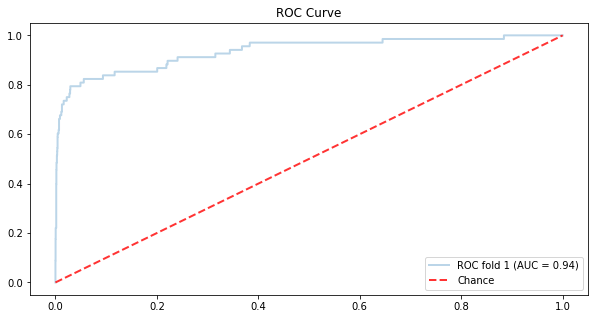

In [115]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = metrics.roc_curve(y_test_l2, scores, pos_label=1)
roc_auc = roc_auc_score(y_test_l2, scores)

fig = plt.figure(figsize = (10,5))
plt.plot(fpr, tpr, alpha=0.3, lw=2, label='ROC fold %d (AUC = %0.2f)' % (1, roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.legend(loc = 'lower right')
plt.title("ROC Curve")

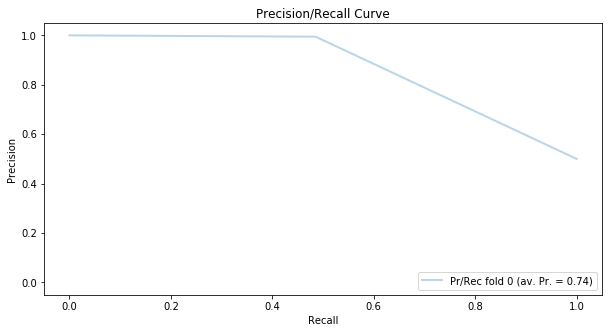

In [116]:
precision, recall, thresholds = precision_recall_curve(y_test_l2, y_pred, sample_weight=weights)
      
fig = plt.figure(figsize = (10,5))
plt.plot(recall, precision, lw=2, alpha=0.3, label='Pr/Rec fold %d (av. Pr. = %0.2f)' % (i, prec))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve')
plt.legend(loc="lower right")
plt.show()